In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import keras
import PIL

import keras.backend as K
from tensorflow.python.framework import ops

from scipy import ndimage

Using TensorFlow backend.


In [2]:
# Load model
# Can be downloaded here: https://drive.google.com/file/d/1gq7QFVzBxzw-jGiKB1siJzvxg5mGuUH6/view
# Original CNTK model was trained by kanotype: http://twitter.com/kanotype
classif_model = keras.models.load_model("kanotype_deepdanbooru_resnet-custom-v2.hdf5")

# Load tags
with open("kanotype_deepdanbooru_resnet-custom-v2_tags.txt", 'r') as tags_stream:
    tags = np.array([tag for tag in (tag.strip() for tag in tags_stream) if tag])

C:\Python\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# Load image
# This is this image (not included in repo for obvious reasons): https://danbooru.donmai.us/posts/3594558
in_path = "censorship_test.jpg"

image = np.array(PIL.Image.open(in_path).convert('RGB').resize((299, 299))) / 255.0
image_arr = np.array([image])

# Decode
results = classif_model.predict(image_arr).reshape(tags.shape[0])

In [4]:
#classif_model.summary()

In [5]:
# For grad-cam: Create gradient class selector variable
class_selector_shape = (len(tags), 1)
class_selector_var = tf.get_variable("gradcam_class_selector", class_selector_shape)

In [6]:
out_layer = classif_model.layers[-1].output
gradcam_loss_func = tf.math.multiply(out_layer, class_selector_var)
gradcam_loss = tf.math.reduce_sum(gradcam_loss_func)
grads_vars = tf.gradients(gradcam_loss, [classif_model.layers[0].input])

In [7]:
sess = K.get_session()

In [8]:
# Threshold and get tags
threshold = 0.1
result_tags = {}
for i in range(len(tags)):
    if results[i] > threshold:
        result_tags[tags[i]] = results[i]

# Print in order        
sorted_tags = reversed(sorted(result_tags.keys(), key = lambda x: result_tags[x]))
for tag in sorted_tags:
    print('{0: <32} {1:04f}'.format(tag, result_tags[tag]))

1girl                            0.997812
breasts                          0.995359
nipples                          0.989224
solo                             0.966959
nude                             0.954145
rating:questionable              0.925104
yellow_eyes                      0.919591
score:very_good                  0.896715
pointy_ears                      0.855211
navel                            0.830432
water                            0.738381
horns                            0.729820
wading                           0.705287
pussy                            0.650098
blonde_hair                      0.619185
large_breasts                    0.601952
looking_at_viewer                0.578979
smile                            0.509732
wet                              0.506163
moon                             0.480328
tail                             0.470815
medium_breasts                   0.447100
pubic_hair                       0.431864
short_hair                       0

In [9]:
def gradcam(classes):
    """
    Get gradient at inputs that maximizes the given class(es)
    """
    if not isinstance(classes, list):
        classes = [classes]
        
    class_nhot = np.zeros(len(tags))
    for gradcam_class in classes:
        class_idx = list(tags).index(gradcam_class)
        class_nhot[class_idx] = 1.0
    class_nhot = class_nhot.reshape(class_nhot.shape[0], 1)

    return sess.run([
        class_selector_var.assign(class_nhot), 
        grads_vars[0]
    ], feed_dict = {classif_model.layers[0].input: image_arr})[1][0]
    

In [10]:
# Find gradients for all result tags
# This is very slow right now. it should be possible to calculate gradients for all of these at once, I think?
gradcam_maps = {}
for idx, tag in enumerate(result_tags.keys()):
    print("Processing tags, {} of {}".format(idx + 1, len(result_tags)))
    gradcam_maps[tag] = gradcam(tag)

Processing tags, 1 of 49
Processing tags, 2 of 49
Processing tags, 3 of 49
Processing tags, 4 of 49
Processing tags, 5 of 49
Processing tags, 6 of 49
Processing tags, 7 of 49
Processing tags, 8 of 49
Processing tags, 9 of 49
Processing tags, 10 of 49
Processing tags, 11 of 49
Processing tags, 12 of 49
Processing tags, 13 of 49
Processing tags, 14 of 49
Processing tags, 15 of 49
Processing tags, 16 of 49
Processing tags, 17 of 49
Processing tags, 18 of 49
Processing tags, 19 of 49
Processing tags, 20 of 49
Processing tags, 21 of 49
Processing tags, 22 of 49
Processing tags, 23 of 49
Processing tags, 24 of 49
Processing tags, 25 of 49
Processing tags, 26 of 49
Processing tags, 27 of 49
Processing tags, 28 of 49
Processing tags, 29 of 49
Processing tags, 30 of 49
Processing tags, 31 of 49
Processing tags, 32 of 49
Processing tags, 33 of 49
Processing tags, 34 of 49
Processing tags, 35 of 49
Processing tags, 36 of 49
Processing tags, 37 of 49
Processing tags, 38 of 49
Processing tags, 39 o

In [11]:
def norm_clip_grads(grads):
    """
    Normalize gradcam gradients by clipping them to between 0 and 
    the 99th percentile and then mapping that range to 0 -> 1
    """
    upper_quantile = np.quantile(grads, 0.99)
    clipped_grads = np.clip(grads, 0.0, upper_quantile)
    return clipped_grads / upper_quantile

def postprocess_grads(grads, filter_width = 10):
    """
    Normalize gradients, take the mean and apply
    a median filter
    """
    gradcam_map = np.mean(norm_clip_grads(grads), axis = -1)
    return ndimage.median_filter(gradcam_map, filter_width)
 
def threshold_map(gradcam_map, all_maps, filter_width = 10):
    """
    Refine gradcam map by applying a threshold mask that zeroes out
    areas where the map is not bigger than the average of all maps
    (i.e. remove areas that are only "generally interesting" instead
    of interesting for this tag specifically)
    """
    threshold_mask = gradcam_map > np.mean(all_maps, axis = 0)
    return ndimage.median_filter(threshold_mask, filter_width) * gradcam_map

def mask_for_tags(tags, gradcam_maps, clip_value = 0.3, regu_value = 0.0, median_filter_width = 10):
    """
    Given tag(s) and a set of (normalized) gradcam maps, generate a mask of pixels
    that contribute to the image being assigned those tags
    
    Maps are combined multiplicatively
    """
    if not isinstance(tags, list):
        tags = [tags]
    
    tags_map = np.ones(gradcam_maps[tags[0]].shape)
    for tag in tags:
        tag_map = threshold_map(gradcam_maps[tag], list(gradcam_maps.values()))
        tag_map = ndimage.median_filter(tag_map, median_filter_width)
        tags_map *= tag_map
        
    tags_map /= np.max(tags_map)
    tags_map = np.maximum(tags_map, clip_value)
    tags_map += regu_value
    tags_map /= np.max(tags_map)
    
    return tags_map

def show_mask(image, mask):
    """
    Show a nice plot of an image, a mask, and the masked image
    """
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel("Input image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, vmin = 0.0, vmax = 1.0)
    plt.xlabel("Activation mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image * np.repeat(mask, 3).reshape(image.shape))
    plt.xlabel("Masked image")

In [12]:
# Make sure that we at least have the safety related tags
rating_tags = ['rating:safe', 'rating:questionable', 'rating:explicit']
for idx, tag in enumerate(rating_tags):
    print("Processing tags, {} of {}".format(idx + 1, len(rating_tags)))
    gradcam_maps[tag] = gradcam(tag)
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

Processing tags, 1 of 3
Processing tags, 2 of 3
Processing tags, 3 of 3


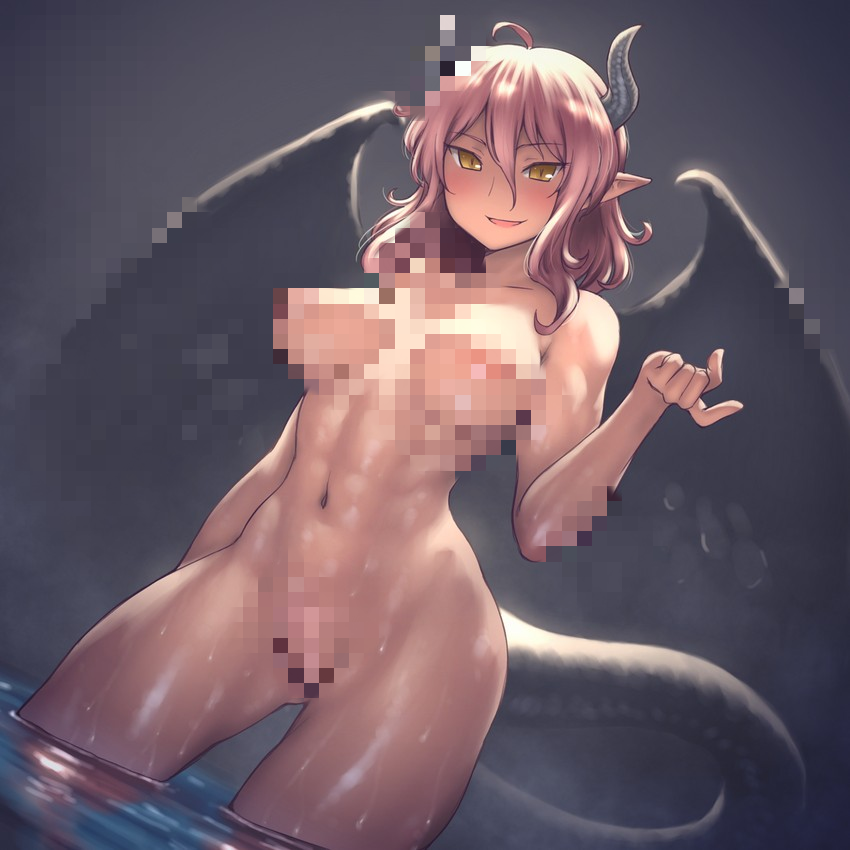

In [16]:
# Which tags do we want to blur out? This might require some fiddling around with
tags_to_censor = [
    "nipples",
    "ass",
    ["penis", "1boy"],
    ["rating:explicit", "rating:questionable"],
]

# Get a combined (additive) mask for these tags
mask = np.zeros(image_arr.shape[1:-1])
for tag_set in tags_to_censor:
    if not isinstance(tag_set, list):
        tag_set = [tag_set]
        
    tag_set_real = []
    for tag in tag_set:
        if tag in gradcam_maps_processed:
            tag_set_real.append(tag)
    if len(tag_set_real) > 0:
        # The threshold can be adjusted to make the mask more or less inclusive, but 0.2 seems
        # to work generally okay
        temp_mask = mask_for_tags(tag_set_real, gradcam_maps_processed, 0.0) < 0.2
        mask += 1.0 - temp_mask
mask = 1.0 - np.clip(mask, 0.0, 1.0)

# Do some hole / noise removal and make the mask a tad larger
mask = ndimage.morphology.binary_dilation(mask, iterations=15, border_value = 1)
mask = ndimage.morphology.binary_erosion(mask, iterations=20, border_value = 1) * 1.0

# Load full res image and make mask the same size
mask_image = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 3, axis = -1) * 255.0
mask_image = PIL.Image.fromarray(mask_image.astype("uint8"))

image_fullres = PIL.Image.open(in_path).convert('RGB')
mask_image = mask_image.resize(image_fullres.size, resample = PIL.Image.LANCZOS)

# Gauss filter to make everything look nice and soft
mask = np.array(mask_image)[:, :, 0] / 255.0
mask = ndimage.gaussian_filter(mask, 3)

# Create a pixelated version of the image
image_fullres_arr = np.array(image_fullres)
image_fullres_pixeled = image_fullres.resize(np.array(image_fullres.size) // 15).resize(image_fullres.size)
pixeled_arr = np.array(image_fullres_pixeled)

# Combined input and pixelated using mask
masked_image = np.array(image_fullres_arr * np.repeat(mask, 3).reshape(image_fullres_arr.shape))
pixeled_image = np.array(pixeled_arr * np.repeat(1.0 - mask, 3).reshape(image_fullres_arr.shape))
final_image = masked_image + pixeled_image

# Display the censored image
PIL.Image.fromarray(final_image.astype("uint8"))